In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from jaxgym.stemoverfocus import (collect_backprojection_coords_and_intensities_jit, 
                                  do_shifted_sum)
import json
import jaxgym.components as comp
%matplotlib widget

Load the Data

In [2]:
fourdstem_array = np.load('fourdstem_array.npy')
params_dict = json.load(open('params.json'))

semi_conv = params_dict['semi_conv']
defocus = params_dict['defocus']
camera_length = params_dict['camera_length']
scan_shape = params_dict['scan_shape'] #YX
det_shape = params_dict['det_shape'] #YX
scan_step = params_dict['scan_step'] #YX
det_px_size = params_dict['det_px_size'] #YX
scan_rotation = params_dict['scan_rotation']
descan_error = params_dict['descan_error']
flip_y = params_dict['flip_y']

print(f"semi_conv: {semi_conv}")
print(f"defocus: {defocus}")
print(f"camera_length: {camera_length}")
print(f"scan_shape: {scan_shape}")
print(f"det_shape: {det_shape}")
print(f"scan_step: {scan_step}")
print(f"det_px_size: {det_px_size}")
print(f"scan_rotation: {scan_rotation}")
print(f"descan_error: {descan_error}")
print(f"flip_y: {flip_y}")


semi_conv: 0.05
defocus: 0.01
camera_length: 1.0
scan_shape: [103, 106]
det_shape: [64, 64]
scan_step: [0.0001, 0.0001]
det_px_size: [0.002, 0.002]
scan_rotation: 0
descan_error: [0, 0, 0, 0, 0, 0, 0, 0]
flip_y: False


Make the model

In [3]:
#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), 
                         scan_step=params_dict['scan_step'], 
                         scan_shape=params_dict['scan_shape'], 
                         scan_rotation=params_dict['scan_rotation'])

Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), 
                           descan_error=params_dict['descan_error'], 
                           offset_x=0., 
                           offset_y=0.)

Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), 
                         det_shape=params_dict['det_shape'], 
                         det_pixel_size=params_dict['det_px_size'])

model = [PointSource, ScanGrid, Descanner, Detector]

In [4]:
shifted_sum = np.zeros(ScanGrid.scan_shape, dtype=np.complex64)
fourdstem_array = np.reshape(fourdstem_array, (scan_shape[0]*scan_shape[1], det_shape[0], det_shape[1]))

Get the backprojected sample pixels and detector intensities on the scan grid

In [5]:
sample_px_ys, sample_px_xs, detector_intensities = collect_backprojection_coords_and_intensities_jit(model, fourdstem_array)

In [6]:
flat_sample_px_ys = np.array(sample_px_ys.flatten())
flat_sample_px_xs = np.array(sample_px_xs.flatten())
flat_detector_intensities = np.array(detector_intensities.flatten())

shifted_sum_image = np.zeros(scan_shape, dtype=np.complex64)
shifted_sum = do_shifted_sum(shifted_sum_image, flat_sample_px_ys, flat_sample_px_xs, flat_detector_intensities)

Ready for interactive portion and libertem.

Text(0.5, 1.0, 'Shifted Sum Image')

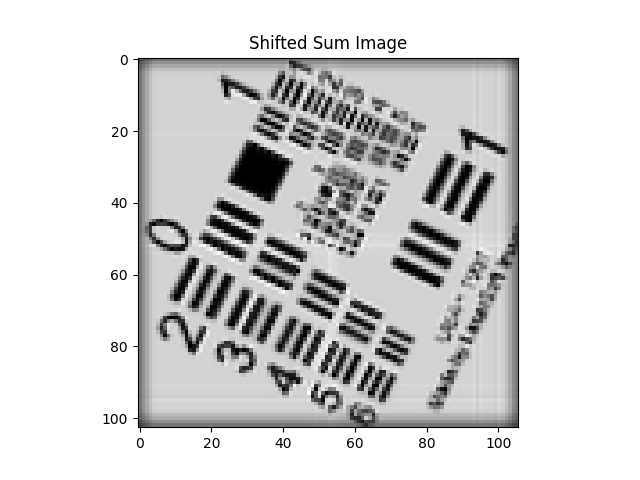

In [7]:
plt.figure()
plt.imshow(np.abs(shifted_sum), cmap='gray')
plt.title('Shifted Sum Image')

In [8]:
import panel as pn
pn.extension()

In [9]:
from libertem_ui.live_plot import ApertureFigure
from bokeh.models.formatters import PrintfTickFormatter

det_shape = params_dict['det_shape']
shifted_sum_array = np.random.uniform(size=det_shape)
shifted_sum_image = np.zeros(scan_shape, dtype=np.complex64)

def run_model_inner(params_dict):
    semi_conv = params_dict['semi_conv']
    defocus = params_dict['defocus']
    camera_length = params_dict['camera_length']
    scan_shape = params_dict['scan_shape'] #YX
    det_shape = params_dict['det_shape'] #YX
    scan_step = params_dict['scan_step'] #YX
    det_px_size = params_dict['det_px_size'] #YX
    scan_rotation = params_dict['scan_rotation']
    descan_error = params_dict['descan_error']
    flip_y = params_dict['flip_y']

    
    #Create ray input z plane
    crossover_z = jnp.zeros((1))

    PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
    ScanGrid = comp.ScanGrid(z=jnp.array([defocus]), 
                            scan_step=scan_step, 
                            scan_shape=scan_shape, 
                            scan_rotation=scan_rotation)

    Descanner = comp.Descanner(z=jnp.array([defocus]), 
                            descan_error=descan_error, 
                            offset_x=0., 
                            offset_y=0.)

    Detector = comp.Detector(z=jnp.array(camera_length), 
                            det_shape=det_shape, 
                            det_pixel_size=det_px_size,
                            flip_y=flip_y)

    model = [PointSource, ScanGrid, Descanner, Detector]


    sample_px_ys, sample_px_xs, detector_intensities = collect_backprojection_coords_and_intensities_jit(model, fourdstem_array)

    flat_sample_px_ys = np.array(sample_px_ys.flatten())
    flat_sample_px_xs = np.array(sample_px_xs.flatten())
    flat_detector_intensities = np.array(detector_intensities.flatten())

    shifted_sum_image = np.zeros(scan_shape, dtype=np.complex64)
    shifted_sum = do_shifted_sum(shifted_sum_image, flat_sample_px_ys, flat_sample_px_xs, flat_detector_intensities)
    

    return np.abs(shifted_sum)


defocus_slider = pn.widgets.FloatSlider(name="defocus", value=0.001, start=0.001, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f m'))
semi_conv_slider = pn.widgets.FloatSlider(name="semi_conv", value=0.01, start=0.01, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f slope'))
camera_length_slider = pn.widgets.FloatSlider(name="camera_length", value=1.0, start=0.1, end=10, format=PrintfTickFormatter(format='%.3f m'))
scan_step_x_slider = pn.widgets.FloatSlider(name="scan_step_x", value=0.0001, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
scan_step_y_slider = pn.widgets.FloatSlider(name="scan_step_y", value=0.0001, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
det_px_size_slider = pn.widgets.FloatSlider(name="det_px_size", value=.002, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
scan_rotation_slider = pn.widgets.FloatSlider(name="scan_rotation", start=0., end=360, step=0.01, value=0.02, format=PrintfTickFormatter(format='%.3f degrees'))

Axx_slider = pn.widgets.FloatSlider(name="Axx", value=4, start=-10, end=10, step=0.1)
Axy_slider = pn.widgets.FloatSlider(name="Axy", value=6, start=-10, end=10, step=0.1)
Ayx_slider = pn.widgets.FloatSlider(name="Ayx", value=-7, start=-10, end=10, step=0.1)
Ayy_slider = pn.widgets.FloatSlider(name="Ayy", value=3, start=-10, end=10, step=0.1)
Cxx_slider = pn.widgets.FloatSlider(name="Cxx", value=-5, start=-10, end=10, step=0.1)
Cxy_slider = pn.widgets.FloatSlider(name="Cxy", value=-3, start=-10, end=10, step=0.1)
Cyx_slider = pn.widgets.FloatSlider(name="Cyx", value=5, start=-10, end=10, step=0.1)
Cyy_slider = pn.widgets.FloatSlider(name="Cyy", value=-4, start=-10, end=10, step=0.1)

figure = (
    ApertureFigure
    .new(shifted_sum_array, tools=False, maxdim=600)
)


def run_model(*e):
    defocus_v = defocus_slider.value
    semi_conv_v = semi_conv_slider.value
    camera_length_v = camera_length_slider.value
    scan_step_vx = scan_step_x_slider.value
    scan_step_vy = scan_step_y_slider.value
    det_px_size_v = det_px_size_slider.value
    scan_rotation_v = scan_rotation_slider.value

    descan_error_v = [Axx_slider.value, Axy_slider.value, Ayx_slider.value, Ayy_slider.value, 
                      Cxx_slider.value, Cxy_slider.value, Cyx_slider.value, Cyy_slider.value]

    params_dict = {
        'defocus': defocus_v,
        'semi_conv': semi_conv_v,
        'camera_length': camera_length_v,
        'scan_shape': scan_shape,
        'det_shape': det_shape,
        'scan_step': [scan_step_vy, scan_step_vx],
        'det_px_size': [det_px_size_v, det_px_size_v],
        'scan_rotation': scan_rotation_v,
        'flip_y': False,
        'descan_error': descan_error_v}

    image = run_model_inner(params_dict)
    figure.im.update(image)


defocus_slider.param.watch(run_model, 'value_throttled')
semi_conv_slider.param.watch(run_model, 'value_throttled')
camera_length_slider.param.watch(run_model, 'value_throttled')
scan_step_x_slider.param.watch(run_model, 'value_throttled')
scan_step_y_slider.param.watch(run_model, 'value_throttled')
det_px_size_slider.param.watch(run_model, 'value_throttled')
scan_rotation_slider.param.watch(run_model, 'value_throttled')

Axx_slider.param.watch(run_model, 'value_throttled')
Axy_slider.param.watch(run_model, 'value_throttled')
Ayx_slider.param.watch(run_model, 'value_throttled')
Ayy_slider.param.watch(run_model, 'value_throttled')
Cxx_slider.param.watch(run_model, 'value_throttled')
Cxy_slider.param.watch(run_model, 'value_throttled')
Cyx_slider.param.watch(run_model, 'value_throttled')
Cyy_slider.param.watch(run_model, 'value_throttled')

pn.Row(
    pn.Column(
        defocus_slider,
        semi_conv_slider,
        camera_length_slider,
        scan_step_x_slider,
        scan_step_y_slider,
        det_px_size_slider,
        scan_rotation_slider,
        pn.Row(
            pn.Column(
                Axx_slider,
                Axy_slider,
                Ayx_slider,
                Ayy_slider
            ),
            pn.Column(
                Cxx_slider,
                Cxy_slider,
                Cyx_slider,
                Cyy_slider
            )
        )
    ),
    figure.layout
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'1d10c531-a7cb-421c-8316-e1ba3fbd21f2': {'version…